In [1]:
import pandas as pd
import numpy as np
import os
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
from screeninfo import get_monitors
from matplotlib.colors import ListedColormap
from matplotlib.patches import Circle
from pandas.api.types import CategoricalDtype
#04_analysis_osm_presence_igm_declaration.py

In [2]:
data = pd.read_parquet("data" + os.sep + "data_igm_proveniance_osm_provincies.parquet")
data.rename(columns={'objects':'total_objects'},inplace=True)
# Raggruppiamo per regione e calcoliamo le percentuali
data_italy = data.groupby(['name_it', 'name_en','layer_name']).agg({'osm_objects': 'sum','total_objects': 'sum'}).reset_index()
data_region = data.groupby(['region','name_it', 'name_en','layer_name']).agg({'osm_objects': 'sum','total_objects': 'sum'}).reset_index()
data_provincies = data.groupby(['province','name_it', 'name_en','layer_name']).agg({'osm_objects': 'sum','total_objects': 'sum'}).reset_index()

In [3]:
description_url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vRgAq3z8-cU_Fy88TUxteuTt_jsvUXIyFUFEbTrRuOXl2KFK-dbAgKAogJxUQtKkdPO5QzJm0M59Pw1/pub?gid=973898789&single=true&output=csv"
description_data = pd.read_csv(description_url)

In [4]:
regions_label = ""
for r in data_region.region.unique():
    regions_label += r + " "


In [5]:
regions_label

'Abruzzo Basilicata Calabria Campania Lazio Marche Molise Puglia Sardegna Sicilia Toscana Umbria '

In [6]:
data_italy['percentage'] = round(data_italy['osm_objects'] / data_italy['total_objects'] * 100,3)
data_italy_with_osm = data_italy[data_italy.percentage >= 1]
data_italy_with_osm['missing'] = 100 - data_italy_with_osm['percentage']
data_italy_with_osm = data_italy_with_osm.sort_values(by='percentage', ascending=False)

/tmp/ipykernel_39253/4004942816.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(data_italy_with_osm['name_en'], rotation=45, ha='right')


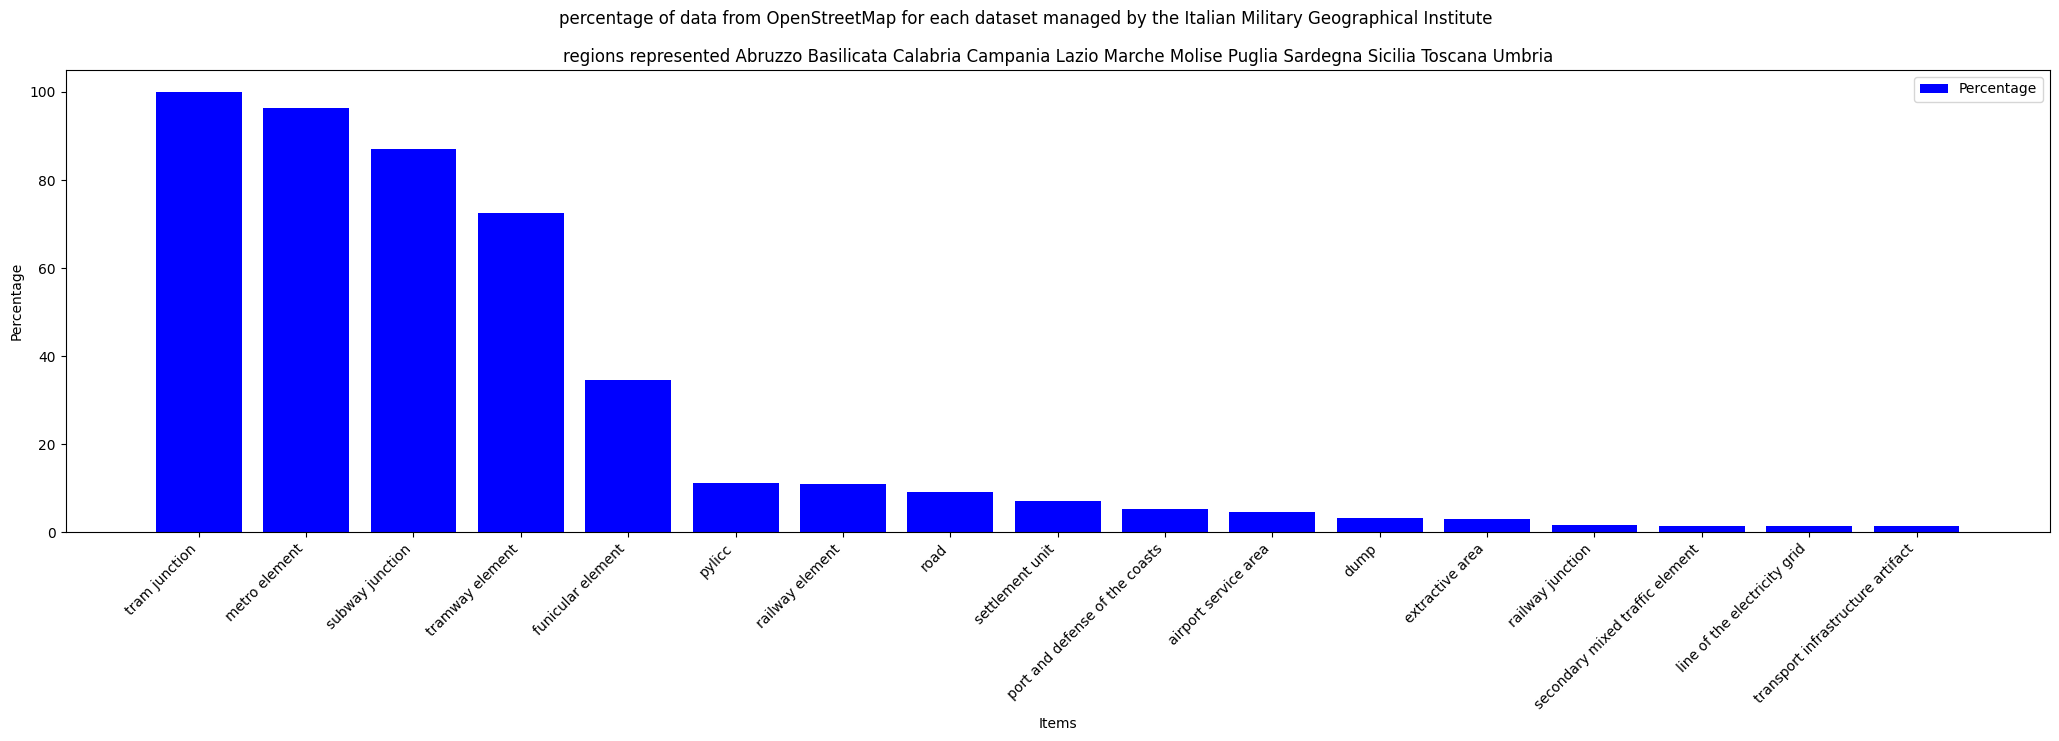

In [7]:
monitor_width = int(get_monitors()[0].width)
fig, ax = plt.subplots(figsize=(monitor_width/100, 6))
plt.bar(data_italy_with_osm['name_en'], data_italy_with_osm['percentage'], color='b', label='Percentage')
#plt.bar(data_italy_with_osm['name_en'], data_italy_with_osm['missing'], bottom=data_italy_with_osm['percentage'], color='g', label='Missing')
plt.xlabel('Items')
plt.ylabel('Percentage')
ax.set_xticklabels(data_italy_with_osm['name_en'], rotation=45, ha='right')
plt.legend()
plt.suptitle("percentage of data from OpenStreetMap for each dataset managed by the Italian Military Geographical Institute")
plt.title("regions represented " + regions_label.rstrip())
plt.show()

In [8]:
data_regione_with_osm_data = data_region[data_region.osm_objects > 0]
data_regione_with_osm_data['percentage'] = round(data_regione_with_osm_data['osm_objects'] / data_regione_with_osm_data['total_objects'] * 100,3)
data_regione_with_osm_data[data_regione_with_osm_data.percentage >= 1]

,region,name_it,name_en,layer_name,osm_objects,total_objects,percentage
6,Abruzzo,area a servizio del trasporto su ferro,area of ​​transport on iron transport,sv_fer,1,81,1.235
51,Abruzzo,manufatto d'infrastruttura di trasporto,transport infrastructure artifact,man_tr,6,76,7.895
59,Abruzzo,opera portuale e di difesa delle coste,port and defense of the coasts,op_por,29,579,5.009
73,Abruzzo,unità insediativa,settlement unit,pe_uins,32,1328,2.410
144,Basilicata,tratto di linea della rete elettrica,line of the electricity grid,tr_ele,20,1551,1.289
...,...,...,...,...,...,...,...
862,Umbria,giunzione ferroviaria,railway junction,gz_fer,4,199,2.010
871,Umbria,manufatto d'infrastruttura di trasporto,transport infrastructure artifact,man_tr,3,40,7.500
886,Umbria,sostegno a traliccio,pylicc,tralic,1928,29308,6.578
892,Umbria,tratto stradale,road,tr_str,60799,63073,96.395


In [9]:
data_regione_with_osm_data['category_en'] = data_regione_with_osm_data.layer_name.apply(lambda x: description_data[description_data.layer_name == x]['category_en'].values[0])

In [10]:
data_regione_with_osm_data_category = data_regione_with_osm_data.groupby(['region','category_en']).agg({'osm_objects': 'sum', 'total_objects': 'sum'})

In [11]:
data_regione_with_osm_data_category['percent_in_osm'] = round((data_regione_with_osm_data_category['osm_objects'] / data_regione_with_osm_data_category['total_objects']) * 100,2)

/tmp/ipykernel_39253/1136015631.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels([f"{x:.0f}%" for x in np.linspace(0, 100, len(colors) + 1)[:-1]])


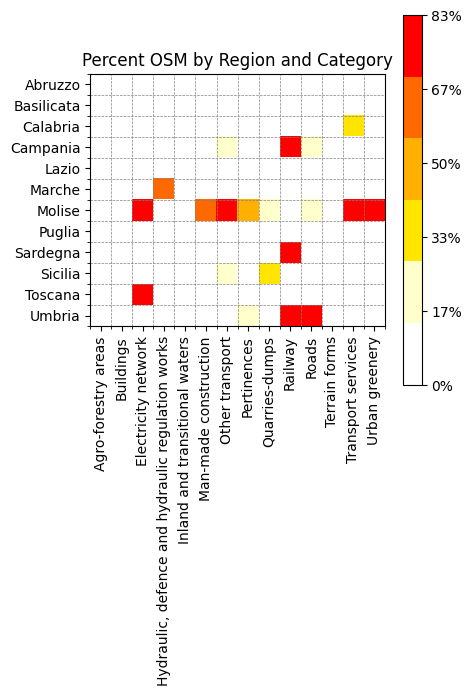

In [12]:
# Creiamo un array numpy 2D con i valori di percent_osm per ogni combinazione di region e macrocategory_en
regions = data_regione_with_osm_data_category.index.levels[0]
categories = data_regione_with_osm_data_category.index.levels[1]
values = np.zeros((len(regions), len(categories)))
for i, region in enumerate(regions):
    for j, category in enumerate(categories):
        try:
            value = data_regione_with_osm_data_category.loc[(region, category), 'percent_in_osm']
            if not np.isnan(value):
                values[i, j] = value
        except KeyError:
            value = 0
            if not np.isnan(value):
                values[i, j] = value


# Creiamo la matrice di colori personalizzata
colors = ['#FFFFFF', '#FFFFCC', '#FFE500', '#FFB000', '#FF6900', '#FF0000']
cmap = ListedColormap(colors)

# Creiamo un oggetto figura e un oggetto assi
fig, ax = plt.subplots()

# Creiamo un'immagine a colori della matrice di valori
im = ax.imshow(values, cmap=cmap, vmax=100)

# Aggiungiamo la griglia
ax.set_xticks(np.arange(len(categories)+1)-0.5, minor=True)
ax.set_yticks(np.arange(len(regions)+1)-0.5, minor=True)
ax.grid(which='minor', color='gray', linestyle='--', linewidth=0.5)

# Aggiungiamo le etichette delle righe e delle colonne
ax.set_xticks(np.arange(len(categories)))
ax.set_xticklabels(categories, rotation='vertical')
ax.set_yticks(np.arange(len(regions)))
ax.set_yticklabels(regions)

# Aggiungiamo i valori all'interno di ogni cella
#for i in range(len(regions)):
#    for j in range(len(categories)):
#        value = values[i, j]
#        if value != 0:
#            ax.text(j, i, f"{value:.2f}%", ha='center', va='center', color='black')

# Aggiungiamo il titolo del grafico e la barra con la legenda
ax.set_title('Percent OSM by Region and Category')
cbar = plt.colorbar(im, ax=ax)
cbar.ax.set_yticklabels([f"{x:.0f}%" for x in np.linspace(0, 100, len(colors) + 1)[:-1]])


# Allarghiamo il grafico
fig.subplots_adjust(right=0.7)

# Mostrare il grafico
plt.show()


/tmp/ipykernel_39253/1291839437.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels([f"{x:.0f}%" for x in np.linspace(0, 100, len(colors) + 1)[:-1]])


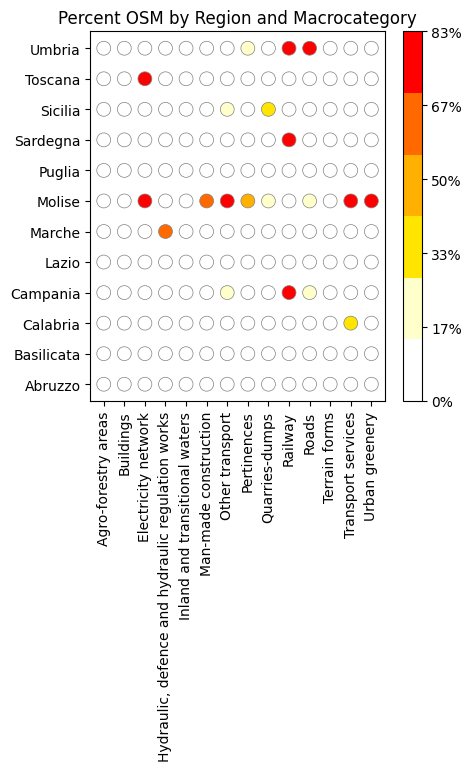

In [13]:
# Creiamo la matrice di colori personalizzata
colors = ['#FFFFFF', '#FFFFCC', '#FFE500', '#FFB000', '#FF6900', '#FF0000']
cmap = ListedColormap(colors)

# Creiamo un oggetto figura e un oggetto assi
fig, ax = plt.subplots()

# Creiamo una griglia di punti di dimensione 100x100 per ogni cella
x, y = np.meshgrid(np.arange(len(categories)), np.arange(len(regions)))
points = ax.scatter(x, y, s=100, c=values, cmap=cmap, edgecolor='gray', linewidth=0.5, vmax=100)

# Aggiungiamo le etichette delle righe e delle colonne
ax.set_xticks(np.arange(len(categories)))
ax.set_xticklabels(categories, rotation='vertical')
ax.set_yticks(np.arange(len(regions)))
ax.set_yticklabels(regions)

# Aggiungiamo i valori all'interno di ogni cella
#for i in range(len(regions)):
#    for j in range(len(categories)):
#        value = values[i, j]
#        if value != 0:
#            ax.text(j, i, f"{value:.2f}%", ha='center', va='center', color='black')

# Aggiungiamo il titolo del grafico e la barra con la legenda
ax.set_title('Percent OSM by Region and Macrocategory')
cbar = plt.colorbar(points, ax=ax)
cbar.ax.set_yticklabels([f"{x:.0f}%" for x in np.linspace(0, 100, len(colors) + 1)[:-1]])

# Allarghiamo il grafico
fig.subplots_adjust(right=0.7)

# Mostrare il grafico
plt.show()

/tmp/ipykernel_39253/2313632219.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels([f"{x:.0f}%" for x in np.linspace(0, 100, len(colors) + 1)[:-1]])


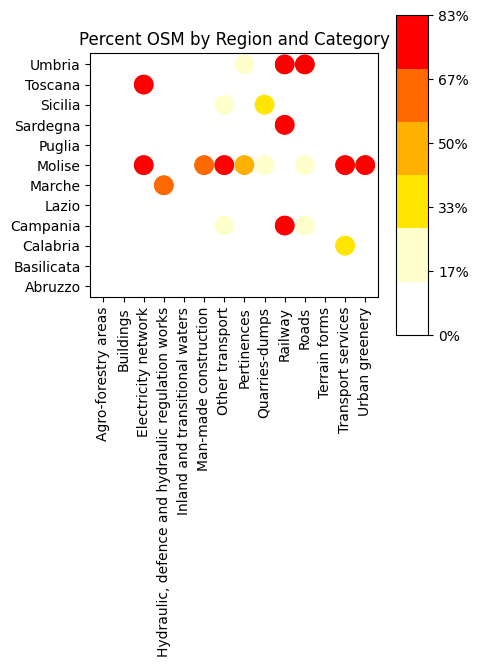

In [14]:
# Creiamo la matrice di colori personalizzata
colors = ['#FFFFFF', '#FFFFCC', '#FFE500', '#FFB000', '#FF6900', '#FF0000']
cmap = ListedColormap(colors)

# Creiamo un oggetto figura e un oggetto assi
fig, ax = plt.subplots(figsize=(6, 6))

# Creiamo una griglia di punti di dimensione 100x100 per ogni cella
x, y = np.meshgrid(np.arange(len(categories)), np.arange(len(regions)))
points = ax.scatter(x, y, s=200, c=values, cmap=cmap, edgecolor='none', vmax=100)

# Aggiungiamo il bordo ai punti impostando il colore del bordo uguale al valore del colore di riempimento
for i in range(len(regions)):
    for j in range(len(categories)):
        value = values[i, j]
        if value != 0:
            index = min(int(value/100*len(colors)), len(colors) - 1)
            ax.add_artist(plt.Circle((j, i), 0.45, edgecolor=colors[index], facecolor=colors[index]))

# Aggiungiamo le etichette delle righe e delle colonne
ax.set_xticks(np.arange(len(categories)))
ax.set_xticklabels(categories, rotation='vertical')
ax.set_yticks(np.arange(len(regions)))
ax.set_yticklabels(regions)


# Aggiungiamo il titolo del grafico e la barra con la legenda
ax.set_title('Percent OSM by Region and Category')

# Impostiamo l'asse come quadrato
ax.set_aspect('equal')

# Aggiungiamo il padding fra i contenuti
fig.subplots_adjust(bottom=0.1, top=1, left=0.1, right=0.8)

# Impostiamo la lunghezza della legenda uguale all'altezza della matrice
leg_height = ax.get_position().height
cbar = plt.colorbar(points, ax=ax, aspect=10, shrink=leg_height)

# Impostiamo le etichette della legenda
cbar.ax.set_yticklabels([f"{x:.0f}%" for x in np.linspace(0, 100, len(colors) + 1)[:-1]])

# Allarghiamo il grafico
fig.subplots_adjust(right=0.7)

# Mostrare il grafico
plt.show()


In [15]:
data_provincies_with_osm_data = data_provincies[data_provincies.osm_objects > 0]
data_provincies_with_osm_data['percentage'] = round(data_provincies_with_osm_data['osm_objects'] / data_provincies_with_osm_data['total_objects'] * 100,3)
data_provincies_with_osm_data = data_provincies_with_osm_data[data_provincies.osm_objects > 0]

/tmp/ipykernel_39253/1859529673.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_provincies_with_osm_data = data_provincies_with_osm_data[data_provincies.osm_objects > 0]


In [16]:
data_provincies_with_osm_data['macrocategory_en'] = data_provincies_with_osm_data.layer_name.apply(lambda x: description_data[description_data.layer_name == x]['macro_category_en'].values[0])

In [17]:
data_provincies_with_osm_data

,province,name_it,name_en,layer_name,osm_objects,total_objects,percentage,macrocategory_en
29,Ancona,edificio,building,edifc,254,113247,0.224,Buildings and human settlements
30,Ancona,edificio minore,minor building,edi_min,1,1170,0.085,Buildings and human settlements
34,Ancona,elemento di viabilità mista secondaria,secondary mixed traffic element,el_vms,51,14267,0.357,"Roads, mobility and transport"
35,Ancona,elemento ferroviario,railway element,el_fer,1,939,0.106,"Roads, mobility and transport"
59,Ancona,opera portuale e di difesa delle coste,port and defense of the coasts,op_por,124,188,65.957,Buildings and human settlements
...,...,...,...,...,...,...,...,...
4338,Viterbo,area estrattiva,extractive area,cv_aes,20,91,21.978,Appurtenant areas
4356,Viterbo,edificio minore,minor building,edi_min,18,81192,0.022,Buildings and human settlements
4397,Viterbo,tratto di linea della rete elettrica,line of the electricity grid,tr_ele,1,17714,0.006,Underground utility networks
4398,Viterbo,tratto stradale,road,tr_str,6,25345,0.024,"Roads, mobility and transport"


In [18]:
#data_provincies_with_osm_data[data_provincies_with_osm_data['province'] == 'Ragusa'].sort_values(by="percentage", ascending=False)

In [19]:
#data_regione_with_osm_data[data_regione_with_osm_data['region'] == 'Sicilia'].sort_values(by="percentage", ascending=False)

In [20]:
#data_regione_with_osm_data.region.unique()

In [21]:
data_italy['macrocategory_en'] = data_italy.layer_name.apply(lambda x: description_data[description_data.layer_name == x]['macro_category_en'].values[0])

In [22]:
data_italy

,name_it,name_en,layer_name,osm_objects,total_objects,percentage,macrocategory_en
0,acqua interna,internal water,acq_in,0,3065,0.000,Administrative areas
1,acqua territoriale,territorial water,acq_ter,0,37,0.000,Administrative areas
2,affioramento naturale dell'acqua,natural outcrop of water,af_acq,0,17224,0.000,Hydrography
3,alveo,riverbed,alveo,0,4426,0.000,Orography
4,ambito omogeneo per la metainformazione,homogeneous scope for metainformation,meta,0,6516,0.000,Geodetic and photogrammetric information
...,...,...,...,...,...,...,...
71,tratto di linea della rete elettrica,line of the electricity grid,tr_ele,5073,361992,1.401,Underground utility networks
72,tratto stradale,road,tr_str,269872,2999288,8.998,"Roads, mobility and transport"
73,unità insediativa,settlement unit,pe_uins,3077,43700,7.041,Appurtenant areas
74,vertice di rete,network vertex,v_rete,0,18657,0.000,Geodetic and photogrammetric information


In [23]:
data_italy_macrocategory = data_italy.groupby('macrocategory_en').agg({'osm_objects': 'sum', 'total_objects': 'sum'})
data_italy_macrocategory['percent_osm'] = round((data_italy_macrocategory['osm_objects'] / data_italy_macrocategory['total_objects'] * 100),2)

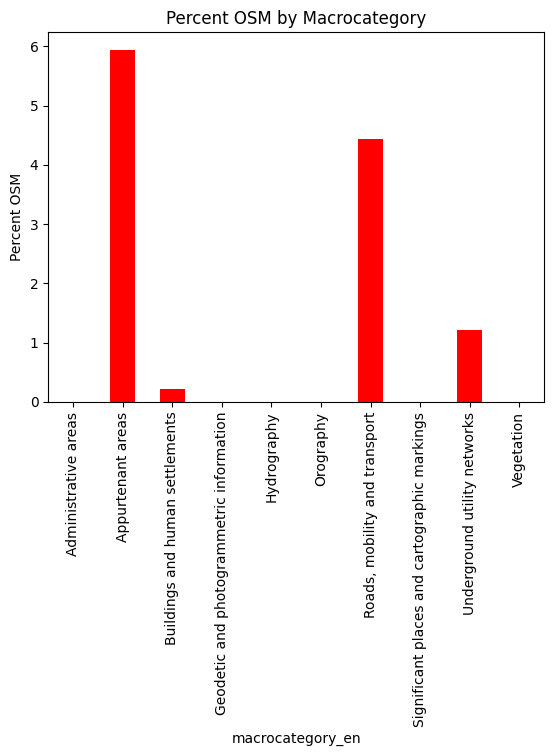

In [24]:
# Creiamo un grafico a barre solo per percent_osm
fig, ax = plt.subplots()
data_italy_macrocategory.plot.bar(y='percent_osm', ax=ax, color='red', legend=False)

# Aggiungiamo le etichette delle assi e il titolo del grafico
ax.set_xlabel('macrocategory_en')
ax.set_ylabel('Percent OSM')
ax.set_title('Percent OSM by Macrocategory')

# Mostrare il grafico
plt.show()